In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv
import re
from lxml import etree
from datetime import date,datetime
import pandas as pd
import math
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest = html.xpath('.//td[@id="cpn_desc"]/text()')
    pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    interest = pattern.findall(interest[0])
    
    if(len(interest) == 1):
        interest = interest*years
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    keep_number = 20
    add_number = 5
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name = row
            holding_dict[cb_id] = cb_name
            if cb_id not in keep_dict.keys():
                price = db_df.loc[cb_id]['price']
                db_low = db_df.loc[cb_id]['db_low']
                if(show_price):
                    print("Sell %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
                else:
                    print("Sell %s %s"%(cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in keep_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    

In [12]:
# save historical data

In [13]:
def save_historical_data(db_df,file):
    min_db = db_df['db_low'].min()
    max_db = db_df['db_low'].max()
    mean_db = db_df['db_low'].mean()
    median_db = db_df['db_low'].median()
    quater_db = np.percentile(db_df['db_low'],25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quater", "median", "mean", "max"])
        today_item = [today,str(min_db),str(quater_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "quater", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,quater_db,median_db,mean_db,max_db])
        f.close()
    
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat(get_force_redeem="No"):
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['force_redeem']
        is_list = dat_cell['price_tips']
        
            
        
        force_redeem_boolean = False
        if(get_force_redeem=="No"):
            if(is_force_redeem == None):
                force_redeem_boolean = True
            else:
                force_redeem_boolean = False
        else:
            if(is_force_redeem == None):
                force_redeem_boolean = False
            else:
                force_redeem_boolean = True
        
        if force_redeem_boolean and is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = price
            lst_dat['convert_value'] = dat_cell['convert_value']
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            if(get_force_redeem == "No"):
                lst_dat['next_put_dt'] = next_put_dt
                lst_dat['put_price'] = put_price
                lst_dat['put_convert_price'] = put_convert_price
            
                lst_dat['maturity_dt'] = maturity_dt
                lst_dat['redeem_price'] = redeem_price
                lst_dat['last_time'] = last_time
            
            else:
                lst_dat['redeem_dt']  = redeem_dt
                lst_dat['force_redeem_price'] = force_redeem_price
                lst_dat['force_redeem'] = is_force_redeem
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            

        
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 0.8  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    for item in data_copy:
        id = item['id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_amt_ratio = item['convert_amt_ratio']
        convert_value = item['convert_value']
        
            
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        convert_value = float(convert_value)
        
        new_convert_value = convert_value*(1-convert_amt_ratio*DISCOUNT)
        new_premium = price/new_convert_value - 1
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr   
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
force_redeem_data = get_dat('Yes')
pd.DataFrame.from_dict(force_redeem_data).to_csv(r'CB_force_redeem_list.csv',index=False)

processing 100 items
processing 200 items
processing 300 items
Finished processing 324 items
Finished processing 59 items


In [25]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 340 lines.


In [26]:
redeem_df = redeem_arbitrage(data)

In [27]:
put_df = put_arbitrage(data)

Finished processing 67 items


In [28]:
db_df = double_low_arbitrage(data,redeem_df,put_df)

In [29]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,next_put_dt,put_price,put_convert_price,maturity_dt,redeem_price,last_time,redeem_CAGR,put_CAGR,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,
128100,搜特转债,002503.sz,搜于特,80.610,59.31,35.91%,A,1.53,18.3%,15.0%,2024-03-11,100.000,2.03,2026-03-11,112.000,4.627,0.081534,0.091857,0.592233,130.647575
128087,孚日转债,002083.sz,孚日股份,102.170,90.89,12.41%,AA-,1.02,17.5%,17.5%,2023-12-18,100.000,3.15,2025-12-17,108.000,4.397,0.020519,0.001212,0.307100,132.239962
113610,灵康转债,603669.ss,灵康药业,117.790,114.87,2.55%,AA-,4.66,7.4%,7.4%,2024-11-29,100.000,6.03,2026-11-30,115.000,5.351,0.003861,0.000000,0.089945,137.181542
110033,国贸转债,600755.ss,厦门国贸,116.360,111.76,4.12%,AAA,0.57,8.2%,7.8%,2020-01-05,100.000,4.70,2022-01-05,108.000,0.447,0.000000,0.000000,0.114255,137.842564
110072,广汇转债,600297.ss,广汇汽车,92.530,69.48,33.18%,AA+,0.55,14.8%,14.8%,2024-08-19,100.000,2.82,2026-08-17,110.000,5.063,0.041685,0.031699,0.510606,139.422138
113039,嘉泽转债,601619.ss,嘉泽新能,118.150,111.85,5.63%,AA,2.40,6.1%,5.9%,2024-08-23,100.000,2.42,2026-08-23,108.000,5.079,0.000000,0.000000,0.110519,140.438337
128071,合兴转债,002228.sz,合兴包装,106.000,84.69,25.16%,AA,1.25,6.9%,6.8%,2023-08-15,100.000,2.93,2025-08-15,110.000,4.058,0.017618,0.000000,0.324750,140.754839
132018,G三峡EB1,600900.ss,长江电力,119.400,112.54,6.22%,AAA,2.45,4.1%,4.1%,2023-04-10,100.000,11.72,2024-04-09,108.000,2.707,0.000000,0.000000,0.096936,141.060928
113565,宏辉转债,603336.ss,宏辉果蔬,108.310,89.14,21.51%,AA-,2.75,7.5%,7.5%,2024-02-26,100.000,5.35,2026-02-25,112.000,4.589,0.015973,0.000000,0.292612,141.510832


In [30]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,next_put_dt,put_price,put_convert_price,maturity_dt,redeem_price,last_time,redeem_CAGR,put_CAGR,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,
128085,鸿达转债,002002.sz,鸿达兴业,124.150,125.06,-0.73%,B,1.70,5.0%,5.0%,2023-12-18,100.000,2.74,2025-12-16,118.000,4.395,0.000000,0.0,0.034087,142.129241
113030,东风转债,601515.ss,东风股份,111.730,92.25,21.12%,AA,1.70,3.7%,3.7%,2023-12-25,100.000,4.51,2025-12-23,112.000,4.414,0.008243,0.0,0.248109,143.455704
113009,广汽转债,601238.ss,广汽集团,115.680,100.07,15.60%,AAA,1.67,2.5%,1.8%,2021-01-22,100.680,9.78,2022-01-22,106.000,0.493,0.000000,0.0,0.179582,143.734130
113541,荣晟转债,603165.ss,荣晟环保,120.550,112.64,7.02%,AA-,1.84,5.1%,5.1%,2023-07-24,100.000,7.59,2025-07-22,110.000,3.992,0.000000,0.0,0.115746,145.066572
123096,思创转债,300078.sz,思创医惠,108.000,89.95,20.06%,AA-,2.02,13.1%,12.6%,2025-01-27,100.000,5.78,2027-01-25,118.000,5.504,0.024342,0.0,0.341228,145.168571
110041,蒙电转债,600863.ss,内蒙华电,107.240,90.62,18.33%,AAA,0.90,13.9%,13.9%,2021-12-21,100.000,1.79,2023-12-21,106.000,2.405,0.001109,0.0,0.331462,145.264477
123082,北陆转债,300016.sz,北陆药业,110.500,96.25,14.80%,A+,2.33,14.5%,12.0%,2024-12-06,100.000,6.17,2026-12-06,115.000,5.367,0.016593,0.0,0.298701,145.811413
128057,博彦转债,002649.sz,博彦科技,120.890,117.76,2.65%,AA-,1.71,10.5%,9.3%,2023-03-05,100.000,5.95,2025-03-05,112.000,3.611,0.000000,0.0,0.120720,146.191700
113607,伟20转债,603568.ss,伟明环保,123.410,116.90,5.56%,AA,5.60,3.8%,3.8%,2024-11-01,100.000,15.20,2026-11-01,110.000,5.271,0.000000,0.0,0.088788,146.959673


In [31]:
buy_sell_db(db_df,'mycb_list.csv',show_price=False)

Sell 110071 湖盐转债
Sell 123087 明电转债

Add  128100 搜特转债
Add  128087 孚日转债
Add  113610 灵康转债
Add  110033 国贸转债
Add  110072 广汇转债

Buy  128090 汽模转2
Buy  113030 东风转债
Buy  113541 荣晟转债
Buy  123096 思创转债
Buy  110041 蒙电转债
Buy  123082 北陆转债
Buy  128057 博彦转债
Buy  113607 伟20转债
Buy  123106 正丹转债


In [32]:
save_historical_data(db_df,'db_history.csv')

In [33]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,next_put_dt,put_price,put_convert_price,maturity_dt,redeem_price,last_time,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,79.680,27.88,185.83%,BB,3.82,45.9%,39.6%,2023-04-03,100.000,11.38,2025-04-02,115.000,3.688,102.00,0.147776,1.791781
128100,搜特转债,002503.sz,搜于特,80.610,59.31,35.91%,A,1.53,18.3%,15.0%,2024-03-11,100.000,2.03,2026-03-11,112.000,4.627,102.48,0.091857,2.731507
113595,花王转债,603007.ss,ST花王,85.380,45.52,87.56%,A,0.91,31.4%,31.2%,2024-07-22,100.000,4.84,2026-07-20,116.000,4.986,102.64,0.061275,3.095890
128044,岭南转债,002717.sz,岭南股份,96.123,48.22,99.33%,AA-,0.97,20.6%,15.1%,2022-08-14,100.000,4.14,2024-08-14,107.000,3.055,102.00,0.052669,1.156164
113017,吉视转债,601929.ss,吉视传媒,98.850,61.02,62.00%,AA+,0.80,27.8%,27.8%,2021-12-27,100.000,2.06,2023-12-27,106.000,2.422,101.04,0.042537,0.526027
113596,城地转债,603887.ss,城地香江,91.270,36.69,148.79%,AA-,0.97,38.1%,29.9%,2024-07-29,100.000,16.98,2026-07-27,108.000,5.005,102.80,0.038928,3.115068
110072,广汇转债,600297.ss,广汇汽车,92.530,69.48,33.18%,AA+,0.55,14.8%,14.8%,2024-08-19,100.000,2.82,2026-08-17,110.000,5.063,102.16,0.031699,3.172603
127019,国城转债,000688.sz,国城矿业,93.431,48.91,91.03%,AA,4.75,7.3%,7.3%,2024-07-15,100.000,14.74,2026-07-14,110.000,4.970,102.40,0.030241,3.076712
113589,天创转债,603608.ss,天创时尚,95.000,48.49,95.90%,AA,1.48,23.5%,23.5%,2024-06-24,100.000,8.60,2026-06-23,110.000,4.912,102.48,0.025421,3.019178


In [34]:
def plot_history(file):
    his = pd.read_csv(file, sep=',')
    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'quater', data=his, marker='s', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='v', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.legend()
    # show graph
    plt.show()

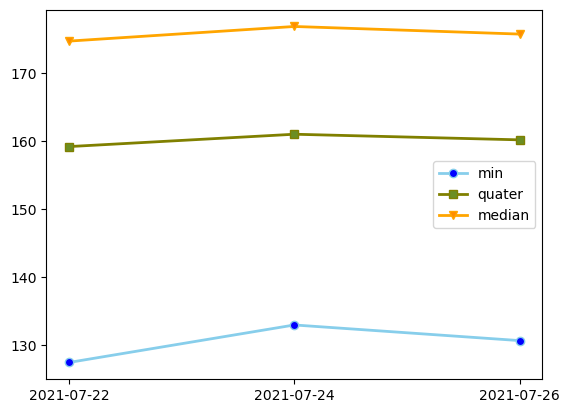

In [35]:
plot_history('db_history.csv')